In [1]:
%matplotlib inline

import types
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

### Functions 

In [2]:
def transform(column, transforms):
    transformation = transforms[column.name]
    # For quarterly data like GDP, we will compute
    # annualized percent changes
    mult = 4 if column.index.freqstr[0] == 'Q' else 1
    
    # 1 => No transformation
    if transformation == 1:
        pass
    # 2 => First difference
    elif transformation == 2:
        column = column.diff()
    # 3 => Second difference
    elif transformation == 3:
        column = column.diff().diff()
    # 4 => Log
    elif transformation == 4:
        column = np.log(column)
    # 5 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    #      with optional multiplier for annualization
    elif transformation == 5:
        column = np.log(column).diff() * 100 * mult
    # 6 => Log second difference, multiplied by 100
    #      with optional multiplier for annualization
    elif transformation == 6:
        column = np.log(column).diff().diff() * 100 * mult
    # 7 => Exact percent change, multiplied by 100
    #      with optional annualization
    elif transformation == 7:
        column = ((column / column.shift(1))**mult - 1.0) * 100
        
    return column

def remove_outliers(dta):
    # Compute the mean and interquartile range
    mean = dta.mean()
    iqr = dta.quantile([0.25, 0.75]).diff().T.iloc[:, 1]
    
    # Replace entries that are more than 10 times the IQR
    # away from the mean with NaN (denotes a missing entry)
    mask = np.abs(dta) > mean + 10 * iqr
    treated = dta.copy()
    treated[mask] = np.nan

    return treated

def load_fredmd_data(vintage):
    base_url = 'https://files.stlouisfed.org/files/htdocs/fred-md/'
    
    # - FRED-MD --------------------------------------------------------------
    # 1. Download data
    orig_m = (pd.read_csv(f'{base_url}/monthly/{vintage}.csv')
                .dropna(how='all'))
    
    # 2. Extract transformation information
    transform_m = orig_m.iloc[0, 1:]
    orig_m = orig_m.iloc[1:]

    # 3. Extract the date as an index
    orig_m.index = pd.PeriodIndex(orig_m.sasdate.tolist(), freq='M')
    orig_m.drop('sasdate', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_m = orig_m.apply(transform, axis=0,
                         transforms=transform_m)

    # 5. Remove outliers (but not in 2020)
    dta_m.loc[:'2019-12'] = remove_outliers(dta_m.loc[:'2019-12'])

    # - FRED-QD --------------------------------------------------------------
    # 1. Download data
    orig_q = (pd.read_csv(f'{base_url}/quarterly/{vintage}.csv')
                .dropna(how='all'))

    # 2. Extract factors and transformation information
    factors_q = orig_q.iloc[0, 1:]
    transform_q = orig_q.iloc[1, 1:]
    orig_q = orig_q.iloc[2:]

    # 3. Extract the date as an index
    orig_q.index = pd.PeriodIndex(orig_q.sasdate.tolist(), freq='Q')
    orig_q.drop('sasdate', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_q = orig_q.apply(transform, axis=0,
                          transforms=transform_q)

    # 5. Remove outliers (but not in 2020)
    dta_q.loc[:'2019Q4'] = remove_outliers(dta_q.loc[:'2019Q4'])
    
    # - Output datasets ------------------------------------------------------
    return types.SimpleNamespace(
        orig_m=orig_m, orig_q=orig_q,
        dta_m=dta_m, transform_m=transform_m,
        dta_q=dta_q, transform_q=transform_q, factors_q=factors_q)

We will call this `load_fredmd_data` function for each vintage from February 2020 through June 2020.

In [3]:
# Load the vintages of data from FRED
dta = {date: load_fredmd_data(date)
       for date in ['2020-02', '2020-03', '2020-04', '2020-05', '2020-06']}

In [4]:
dta['2020-02'].orig_q.tail()

,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,PRFIx,...,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P: indust,S&P div yield,S&P PE ratio
2018Q4,18783.548,13066.302,1705.2479,8462.1346,2938.9272,3429.477,3322.9119,1279.1699,2735.8068,593.0723,...,7620677.23,398940.33,19188651.20,11567.97,605.58,1910.2298,2692.0000,3625.8467,1.9820,22.3811
2019Q1,18927.281,13103.317,1706.3378,8482.6008,2954.6374,3481.088,3349.3114,1278.8561,2765.5477,591.5122,...,7725179.92,399267.98,19497964.39,11772.78,608.46,1934.8358,2722.0767,3668.4667,2.0053,21.6410
2019Q2,19021.860,13250.040,1759.3088,8540.8749,3001.2841,3424.653,3337.2745,1281.5136,2758.5558,587.0884,...,7755245.22,392101.58,19739743.30,11984.50,605.93,1977.8663,2882.8933,3892.4500,1.9322,21.9386
2019Q3,19121.112,13353.121,1793.8927,8587.3728,3029.9919,3416.180,3330.3389,1269.2974,2742.6664,593.7906,...,7834837.89,387421.88,20002808.82,12167.97,601.69,2022.3014,2958.5900,3994.6867,1.9216,22.0320
2019Q4,19220.490,13410.416,1805.3159,8634.3291,3027.8269,3363.567,3325.9249,1254.9372,2726.5041,602.7240,...,NaN,NaN,NaN,NaN,NaN,NaN,3086.4433,4164.2800,1.8771,22.8262


In [5]:
# Print some information about the base dataset
n, k = dta['2020-02'].dta_m.shape
start = dta['2020-02'].dta_m.index[0]
end = dta['2020-02'].dta_m.index[-1]

print(f'For vintage 2020-02, there are {k} series and {n} observations,'
      f' over the period {start} to {end}.')

For vintage 2020-02, there are 128 series and 733 observations, over the period 1959-01 to 2020-01.


To see how the transformation and outlier removal works, here we plot three graphs of the RPI variable ("Real Personal Income") over the period 2000-01 - 2020-01:

1. The original dataset (which is in Billions of Chained 2012 Dollars)
2. The transformed data (RPI had a transformation code of "5", corresponding to log first difference)
3. The transformed data, with outliers removed

Notice that the large negative growth rate in January 2013 was deemed to be an outlier and so was replaced with a missing value (a `NaN` value).

The [BEA release at the time](https://www.bea.gov/news/2013/personal-income-and-outlays-january-2013) noted that this was related to "the effect of special factors, which boosted employee contributions for government social insurance in January [2013] and which had boosted wages and salaries and personal dividends in December [2012].".

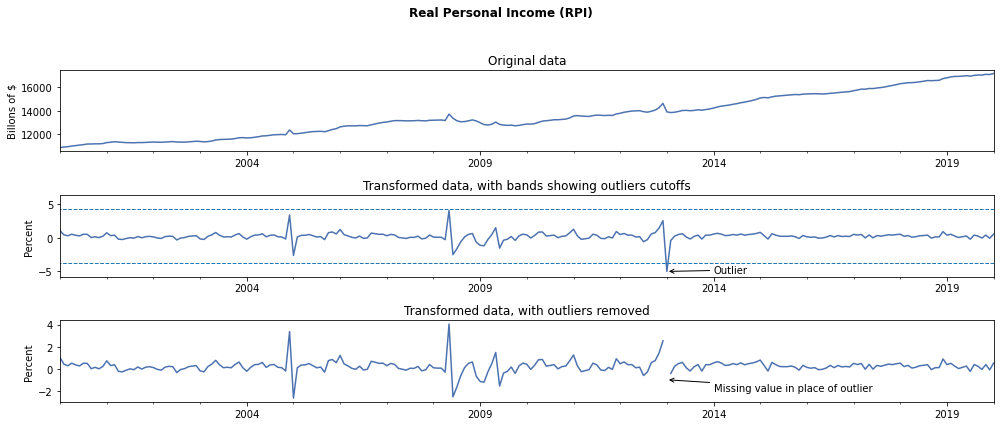

In [6]:
with sns.color_palette('deep'):
    fig, axes = plt.subplots(3, figsize=(14, 6))

    # Plot the raw data from the February 2020 vintage, for:
    # 
    vintage = '2020-02'
    variable = 'RPI'
    start = '2000-01'
    end = '2020-01'

    # 1. Plot the original dataset, for 2000-01 through 2020-01
    dta[vintage].orig_m.loc[start:end, variable].plot(ax=axes[0])
    axes[0].set(title='Original data', xlim=('2000','2020'), ylabel='Billons of $')

    # 2. Plot the transformed data, still including outliers
    # (we only stored the transformation with outliers removed, so
    # here we'll manually perform the transformation)
    transformed = transform(dta[vintage].orig_m[variable],
                            dta[vintage].transform_m)
    transformed.loc[start:end].plot(ax=axes[1])
    mean = transformed.mean()
    iqr = transformed.quantile([0.25, 0.75]).diff().iloc[1]
    axes[1].hlines([mean - 10 * iqr, mean + 10 * iqr],
                   transformed.index[0], transformed.index[-1],
                   linestyles='--', linewidth=1)
    axes[1].set(title='Transformed data, with bands showing outliers cutoffs',
                xlim=('2000','2020'), ylim=(mean - 15 * iqr, mean + 15 * iqr),
                ylabel='Percent')
    axes[1].annotate('Outlier', xy=('2013-01', transformed.loc['2013-01']),
                     xytext=('2014-01', -5.3), textcoords='data',
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)

    # 3. Plot the transformed data, with outliers removed (see missing value for 2013-01)
    dta[vintage].dta_m.loc[start:end, 'RPI'].plot(ax=axes[2])
    axes[2].set(title='Transformed data, with outliers removed',
                xlim=('2000','2020'), ylabel='Percent')
    axes[2].annotate('Missing value in place of outlier', xy=('2013-01', -1),
                     xytext=('2014-01', -2), textcoords='data',
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    
    fig.suptitle('Real Personal Income (RPI)',
                 fontsize=12, fontweight=600)

    fig.tight_layout(rect=[0, 0.00, 1, 0.95]);

In [8]:
# Original data 
dta['2020-02'].orig_m

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
1959-01,2437.296,2288.8,17.302,2.922588e+05,18235.77392,22.6250,23.4581,22.1904,32.4078,21.9882,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.00,12298.00,84.2043,NaN
1959-02,2446.902,2297.0,17.482,2.944295e+05,18369.56308,23.0681,23.7747,22.3827,32.6455,22.1036,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.00,12298.00,83.5280,NaN
1959-03,2462.689,2314.0,17.647,2.934254e+05,18523.05762,23.4004,23.9186,22.4925,32.6455,22.5365,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.00,12349.00,81.6405,NaN
1959-04,2478.744,2330.3,17.584,2.993317e+05,18534.46600,23.8989,24.2641,22.8221,33.1606,22.6807,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.00,12484.00,81.8099,NaN
1959-05,2493.228,2345.8,17.796,3.013730e+05,18679.66354,24.2589,24.4655,23.0418,33.3190,23.1424,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09,17036.522,14120.7,121.554,1.524004e+06,524651.00000,109.4800,104.1240,102.6155,104.7288,118.6729,...,118.043,24.90,28.63,22.26,93.2,16580.8,318895.38,734464.35,3788.6853,16.3081
2019-10,17025.707,14105.5,121.605,1.516833e+06,526420.00000,109.0086,103.8317,102.3164,104.6120,115.1006,...,118.259,24.95,28.68,22.30,95.5,16757.9,319622.35,735160.19,3795.6607,15.9863
2019-11,17089.328,14168.5,121.881,1.525004e+06,527518.00000,109.9726,105.2503,104.2506,106.7311,123.1769,...,118.411,24.98,28.72,22.39,96.8,16903.0,319601.11,735015.08,3833.9875,12.6423
2019-12,17072.122,14157.4,122.026,1.522592e+06,528367.00000,109.5407,104.3965,103.0595,105.1339,120.1546,...,118.754,25.07,28.88,22.44,99.3,16979.0,321148.13,735215.09,3821.3309,13.3469


In [9]:
# Definitions from the Appendix for FRED-MD variables
defn_m = pd.read_csv('data/fredmd_definitions.csv')
defn_m.index = defn_m.fred

# Definitions from the Appendix for FRED-QD variables
defn_q = pd.read_csv('data/fredqd_definitions.csv')
defn_q.index = defn_q.fred

# Example of the information in these files:
defn_m.head()

,group,id,tcode,fred,description,gsi,gsi:description,asterisk
fred,,,,,,,,
RPI,Output and Income,1,5,RPI,Real Personal Income,M_14386177,PI,NaN
W875RX1,Output and Income,2,5,W875RX1,Real personal income ex transfer receipts,M_145256755,PI less transfers,NaN
INDPRO,Output and Income,6,5,INDPRO,IP Index,M_116460980,IP: total,NaN
IPFPNSS,Output and Income,7,5,IPFPNSS,IP: Final Products and Nonindustrial Supplies,M_116460981,IP: products,NaN
IPFINAL,Output and Income,8,5,IPFINAL,IP: Final Products (Market Group),M_116461268,IP: final prod,NaN


To aid interpretation of the results, we'll replace the names of our dataset with the "description" field.

In [10]:
# Replace the names of the columns in each monthly and quarterly dataset
map_m = defn_m['description'].to_dict()
map_q = defn_q['description'].to_dict()
for date, value in dta.items():
    value.orig_m.columns = value.orig_m.columns.map(map_m)
    value.dta_m.columns = value.dta_m.columns.map(map_m)
    value.orig_q.columns = value.orig_q.columns.map(map_q)
    value.dta_q.columns = value.dta_q.columns.map(map_q)

**Data groups**

Below, we get the groups for each series from the definition files above, and then show how many of the series that we'll be using fall into each of the groups.

We'll also re-order the series by group, to make it easier to interpret the results.

Since we're including the quarterly real GDP variable in our analysis, we need to assign it to one of the groups in the monthly dataset. It fits best in the "Output and income" group.

In [11]:
# Get the mapping of variable id to group name, for monthly variables
groups = defn_m[['description', 'group']].copy()

# Re-order the variables according to the definition CSV file
# (which is ordered by group)
columns = [name for name in defn_m['description']
           if name in dta['2020-02'].dta_m.columns]
for date in dta.keys():
    dta[date].dta_m = dta[date].dta_m.reindex(columns, axis=1)

# Add real GDP (our quarterly variable) into the "Output and Income" group
gdp_description = defn_q.loc['GDPC1', 'description']
groups.loc['GDPC1'] = {'description': gdp_description, 'group': 'Output and Income'}

# Display the number of variables in each group
(groups.groupby('group', sort=False)
       .count()
       .rename({'description': '# series in group'}, axis=1))

,# series in group
group,
Output and Income,18
Labor Market,32
Housing,10
"Consumption, orders, and inventories",14
Money and credit,14
Interest and exchange rates,22
Prices,21
Stock market,5


### Model specification

Now we need to specify all the details of the specific dynamic factor model that we want to estimate. In particular, we will choose:

1. Factor specification, including: how many factors to include, which variables load on which factors, and the order of the (vector) autoregression that the factor evolves according to.

2. Whether or not to standardize the dataset for estimation.

3. Whether to model the idiosyncratic error terms as AR(1) processes or as iid.

In [12]:
# Construct the variable => list of factors dictionary
factors = {row['description']: ['Global', row['group']]
           for ix, row in groups.iterrows()}

# Check that we have the desired output for "Real personal income"
print(factors['Real Personal Income'])

['Global', 'Output and Income']


In [13]:
factor_multiplicities = {'Global': 2}

In [14]:
factor_orders = {'Global': 4}

In [15]:
# Get the baseline monthly and quarterly datasets
start = '2000'
endog_m = dta['2020-02'].dta_m.loc[start:, :]
gdp_description = defn_q.loc['GDPC1', 'description']
endog_q = dta['2020-02'].dta_q.loc[start:, [gdp_description]]

# Construct the dynamic factor model
model = sm.tsa.DynamicFactorMQ(
    endog_m, endog_quarterly=endog_q,
    factors=factors, factor_orders=factor_orders,
    factor_multiplicities=factor_multiplicities)

C:\Users\MChatzouz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\dynamic_factor_mq.py:443: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.factor_block_orders.append(default_block_orders))


2019-09    0.221334
2019-10   -0.063501
2019-11    0.372980
2019-12   -0.100733
2020-01    0.512301
Freq: M, Name: Real Personal Income, dtype: float64

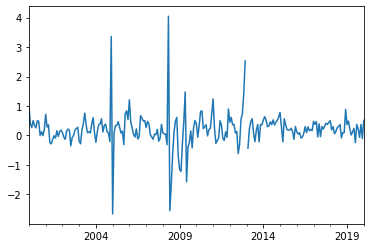

In [16]:
endog_m['Real Personal Income'].plot()
endog_m.tail()['Real Personal Income']

**Model summary**

Because these models can be somewhat complex to set up, it can be useful to check the results of the model's `summary` method. This method produces three tables.

1. **Model specification**: the first table shows general information about the model selected, the sample, factor setup, and other options.

2. **Observed variables / factor loadings**: the second table shows which factors load on which observed variables. This table should be checked to make sure that the `factors` and `factor_multiplicities` arguments were specified as desired.

3. **Factor block orders**: the last table shows the blocks of factors (the factors within each block evolve jointly, while between blocks the factors are independent) and the order of the (vector) autoregression. This table should be checked to make sure that the `factor_orders` argument was specified as desired.

Note that by default, the names of the observed variables are truncated to prevent tables from overflowing. The length before truncation can be specified by changing the value of the `truncate_endog_names` argument.

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                          
============================================================================================
Model:                 Dynamic Factor Model   # of monthly variables:                    128
                   + 10 factors in 9 blocks   # of quarterly variables:                    1
                    + Mixed frequency (M/Q)   # of factor blocks:                          9
                      + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                             2000-01   Standardize variables:                    True
                                  - 2020-01                                                 
                                                                                 Observed variables / factor loadings                                                                                 
======================================================================================================================================================================================================
              Dep. variable   Global.1   Global.2 Output and Income Labor Market     Housing Consumption, orders, and inventories Money and credit Interest and exchange rates     Prices Stock market
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
       Real Personal Income      X          X             X                                                                                                                                           
Real personal income ex ...      X          X             X                                                                                                                                           
                   IP Index      X          X             X                                                                                                                                           
IP: Final Products and N...      X          X             X                                                                                                                                           
IP: Final Products (Mark...      X          X             X                                                                                                                                           
         IP: Consumer Goods      X          X             X                                                                                                                                           
IP: Durable Consumer Goo...      X          X             X                                                                                                                                           
IP: Nondurable Consumer ...      X          X             X                                                                                                                                           
     IP: Business Equipment      X          X             X                                                                                                                                           
              IP: Materials      X          X             X                                                                                                                                           
      IP: Durable Materials      X          X             X                                                                                                                                           
   IP: Nondurable Materials      X          X             X                                                                                                                                           
    IP: Manufacturing (S

### Model fitting / parameter estimation

With the model constructed as shown above, the model can be fit / the parameters can be estimated via the `fit` method. This method does not affect the `model` object that we created before, but instead returns a new `results` object that contains the estimates of the parameters and the state vector, and also allows forecasting and computation of the "news" when updated data arrives.

The default method for parameter estimation in the `DynamicFactorMQ` class is maximum likelihood via the EM algorithm.

**Note**: by default, the `fit` method does not show any output. Here we use the `disp=10` method to print details of every 10th iteration of the EM algorithm, to track its progress.

In [18]:
results = model.fit(disp=10)

EM start iterations, llf=-28556
EM iteration 10, llf=-25703, convergence criterion=0.00045107
EM iteration 20, llf=-25673, convergence criterion=3.1194e-05
EM iteration 30, llf=-25669, convergence criterion=8.8719e-06
EM iteration 40, llf=-25668, convergence criterion=3.7567e-06
EM iteration 50, llf=-25667, convergence criterion=2.0379e-06
EM iteration 60, llf=-25667, convergence criterion=1.3147e-06
EM converged at iteration 69, llf=-25666, convergence criterion=9.7195e-07 < tolerance=1e-06


A summary of the model results including the estimated parameters can be produced using the `summary` method. This method produces three or four sets of tables. To save space in the output, here we are using `display_diagnostics=False` to hide the table showing residual diagnostics for the observed variables, so that only three sets of tables are shown.

1. **Model specification**: the first table shows general information about the model selected, the sample, and summary values like the sample log likelihood and information criteria.

2. **Observation equation**: the second table shows the estimated factor loadings for each observed variable / factor combination, or a dot (.) when a given variable does not load on a given factor. The last one or two columns show parameter estimates related to the idiosyncratic disturbance. In the `idiosyncratic_ar1=True` case, there are two columns at the end, one showing the estimated autoregressive coefficient and one showing the estimated variance of the disturbance innovation.

3. **Factor block transition equations**: the next set of tables show the estimated (vector) autoregressive transition equations for each factor block. The first columns show the autoregressive coefficients, and the final columns show the error variance or covariance matrix.

4. **(Optional) Residual diagnostics**: the last table (optional) shows three diagnostics from the (standardized) residuals associated with each observed variable.

   1. First, the Ljung-Box test statistic for the first lag is shown to test for serial correlation.
   2. Second, a test for heteroskedasticity.
   3. Third, the Jarque-Bera test for normality.
   
   The default for dynamic factor models is not to show these diagnostics, which can be difficult to intepret for quarterly variables. However, the table can be shown by passing the `display_diagnostics=True` argument to the `summary` method.

Note that by default, the names of the observed variables are truncated to prevent tables from overflowing. The length before truncation can be specified by changing the value of the `truncate_endog_names` argument.

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     Dynamic Factor Results                                     
================================================================================================
Dep. Variable:     "Real Personal Income", and 128 more   No. Observations:                  241
Model:                             Dynamic Factor Model   Log Likelihood              -25666.313
                               + 10 factors in 9 blocks   AIC                          52692.627
                                + Mixed frequency (M/Q)   BIC                          55062.289
                                  + AR(1) idiosyncratic   HQIC                         53647.320
Date:                                  Mon, 24 Jul 2023   EM Iterations                       69
Time:                                          16:18:56                                         
Sample:                                      01-31-2000                                         
                                           - 01-31-2020                                         
Covariance Type:                           Not computed                                         
                                                                                                          Observation equation:                                                                                                          
=========================================================================================================================================================================================================================================
           Factor loadings:   Global.1   Global.2 Output and Income Labor Market     Housing Consumption, orders, and inventories Money and credit Interest and exchange rates     Prices Stock market    idiosyncratic: AR(1)       var.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
       Real Personal Income      -0.07      -0.03             -0.05            .           .                                    .                .                           .          .            .                   -0.11       0.96
Real personal income ex ...      -0.10      -0.05             -0.05            .           .                                    .                .                           .          .            .                    0.01       0.89
                   IP Index      -0.15      -0.09              0.24            .           .                                    .                .                           .          .            .                   -0.22       0.20
IP: Final Products and N...      -0.15      -0.07              0.26            .           .                                    .                .                           .          .            .                   -0.41       0.01
IP: Final Products (Mark...      -0.13      -0.07              0.28            .           .                                    .                .                           .          .            .                    0.07       0.04
         IP: Consumer Goods      -0.09      -0.05              0.28            .           .                                    .                .                           .          .            .                   -0.07       0.21
IP: Durable Consumer Goo...      -0.09      -0.07              0.19            .           .                                    .                .                           .          .            .                   -0.19       0.53
IP: Nondurable Consumer ...      -0.05      -0.02              0.21            .           .                                    .                .                           .          .            .                

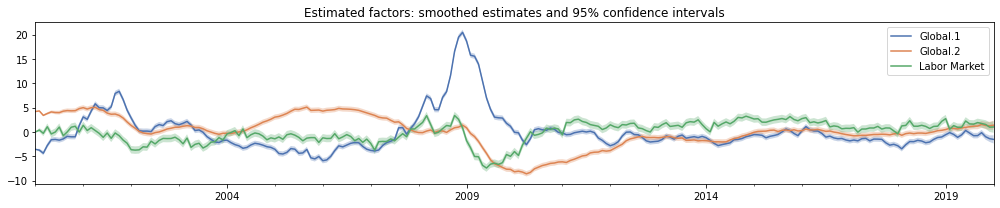

In [20]:
# Get estimates of the global and labor market factors,
# conditional on the full dataset ("smoothed")
factor_names = ['Global.1', 'Global.2', 'Labor Market']
mean = results.factors.smoothed[factor_names]

# Compute 95% confidence intervals
from scipy.stats import norm
std = pd.concat([results.factors.smoothed_cov.loc[name, name]
                 for name in factor_names], axis=1)
crit = norm.ppf(1 - 0.05 / 2)
lower = mean - crit * std
upper = mean + crit * std

with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 3))
    mean.plot(ax=ax)
    
    for name in factor_names:
        ax.fill_between(mean.index, lower[name], upper[name], alpha=0.3)
    
    ax.set(title='Estimated factors: smoothed estimates and 95% confidence intervals')
    fig.tight_layout();

#### Explanatory power of the factors

One way to examine how the factors relate to the observed variables is to compute the explanatory power that each factor has for each variable, by regressing each variable on a constant plus one or more of the smoothed factor estimates and storing the resulting $R^2$, or "coefficient of determination", value.

**Computing $R^2$**

The `get_coefficients_of_determination` method in the results object has three options for the `method` argument:

- `method='individual'` retrieves the $R^2$ value for each observed variable regressed on each individual factor (plus a constant term)
- `method='joint'` retrieves the $R^2$ value for each observed variable regressed on all factors that the variable loads on
- `method='cumulative'` retrieves the $R^2$ value for each observed variable regressed on an expanding set of factors. The expanding set begins with the $R^2$ from a regression of each variable on the first factor that the variable loads on (as it appears in, for example, the summary tables above) plus a constant. For the next factor in the list, the $R^2$ is computed by a regression on the first two factors (assuming that a given variable loads on both factors).

**Example:** top 10 variables explained by the global factors

Below, we compute according to the `method='individual'` approach, and then show the top 10 observed variables that are explained (individually) by each of the two global factors.

- The first global factor explains labor market series well, but also includes Real GDP and a measure of stock market volatility (VXO)
- The second factor appears to largely explain housing-related variables (in fact, this might be an argument for dropping the "Housing" group-specific factor)

In [21]:
rsquared = results.get_coefficients_of_determination(method='individual')

top_ten = []
for factor_name in rsquared.columns[:2]:
    top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                       .iloc[:10].round(2).reset_index())
    top_factor.columns = pd.MultiIndex.from_product([
        [f'Top ten variables explained by {factor_name}'],
        ['Variable', r'$R^2$']])
    top_ten.append(top_factor)
pd.concat(top_ten, axis=1)

Top ten variables explained by Global.1        \
                                            Variable $R^2$   
0                       All Employees: Total nonfarm  0.74   
1          All Employees: Goods-Producing Industries  0.73   
2                       All Employees: Durable goods  0.66   
3                       All Employees: Manufacturing  0.65   
4                     All Employees: Wholesale Trade  0.64   
5        All Employees: Service-Providing Industries  0.63   
6   All Employees: Trade, Transportation & Utilities  0.61   
7                                                VXO  0.61   
8  Real Gross Domestic Product, 3 Decimal (Billio...  0.53   
9                        All Employees: Construction  0.52   

         Top ten variables explained by Global.2        
                                        Variable $R^2$  
0      Housing Starts: Total New Privately Owned  0.65  
1      New Private Housing Permits, South (SAAR)  0.65  
2                          Housing Starts, South  0.65  
3             New Private Housing Permits (SAAR)  0.65  
4       New Private Housing Permits, West (SAAR)  0.64  
5                           Housing Starts, West  0.64  
6    New Private Housing Permits, Midwest (SAAR)  0.56  
7  New Private Housing Permits, Northeast (SAAR)  0.54  
8                        Housing Starts, Midwest  0.52  
9                      Housing Starts, Northeast  0.52

**Plotting $R^2$**

When there are a large number of observed variables, it is often easier to plot the $R^2$ values for each variable. This can be done using the `plot_coefficients_of_determination` method in the results object. It accepts the same `method` arguments as the `get_coefficients_of_determination` method, above.

Below, we plot the $R^2$ values from the "individual" regressions, for each factor. Because there are so many variables, this graphical tool is best for identifying trends overall and within groups, and we do not display the names of the variables on the x-axis label.

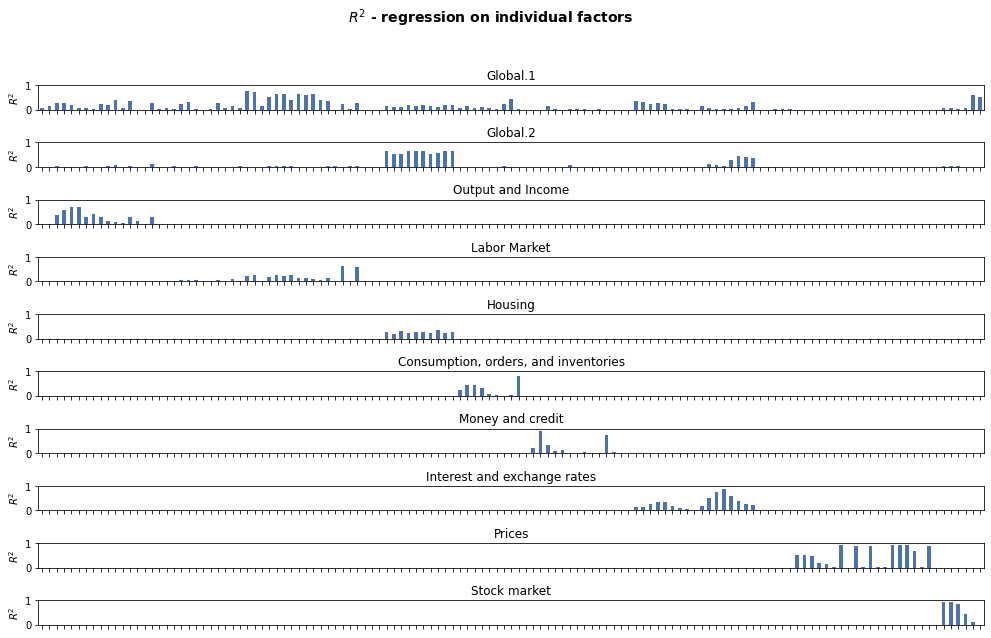

In [22]:
with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='individual', figsize=(14, 9))
    fig.suptitle(r'$R^2$ - regression on individual factors', fontsize=14, fontweight=600)
    fig.tight_layout(rect=[0, 0, 1, 0.95]);

Alternatively, we might look at the overall explanatory value to a given variable of all factors that the variable loads on. To do that, we can use the same function but with `method='joint'` .

To make it easier to identify patterns, we add in shading and labels to identify the different groups of variables, as well as our only quarterly variable, GDP.

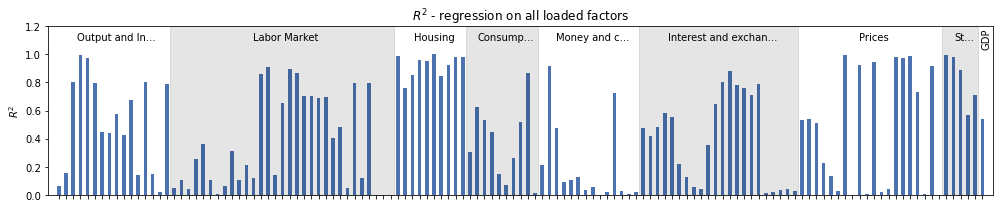

In [23]:
group_counts = defn_m[['description', 'group']]
group_counts = group_counts[group_counts['description'].isin(dta['2020-02'].dta_m.columns)]
group_counts = group_counts.groupby('group', sort=False).count()['description'].cumsum()

with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='joint', figsize=(14, 3));

    # Add in group labels
    ax = fig.axes[0]
    ax.set_ylim(0, 1.2)
    for i in np.arange(1, len(group_counts), 2):
        start = 0 if i == 0 else group_counts[i - 1]
        end = group_counts[i] + 1
        ax.fill_between(np.arange(start, end) - 0.6, 0, 1.2, color='k', alpha=0.1)
    for i in range(len(group_counts)):
        start = 0 if i == 0 else group_counts[i - 1]
        end = group_counts[i]
        n = end - start
        text = group_counts.index[i]
        if len(text) > n:
            text = text[:n - 3] + '...'

        ax.annotate(text, (start + n / 2, 1.1), ha='center')

    # Add label for GDP
    ax.set_xlim(-1.5, model.k_endog + 0.5)
    ax.annotate('GDP', (model.k_endog - 1.1, 1.05), ha='left', rotation=90)

    fig.tight_layout();

### Forecasting

One of the benefits of these models is that we can use the dynamics of the factors to produce forecasts of any of the observed variables. This is straightforward here, using the `forecast` or `get_forecast` results methods. These take a single argument, which must be either:

- an integer, specifying the number of steps ahead to forecast
- a date, specifying the date of the final forecast to make

The `forecast` method only produces a series of point forecasts for all of the observed variables, while the `get_forecast` method returns a new forecast results object, that can also be used to compute confidence intervals. 

**Note**: these forecasts are in the same scale as the variables passed to the `DynamicFactorMQ` constructor, even if `standardize=True` has been used.

Below is an example of the `forecast` method.

In [24]:
# Create point forecasts, 3 steps ahead
point_forecasts = results.forecast(steps=3)

# Print the forecasts for the first 5 observed variables
print(point_forecasts.T.head())

                                                2020-02   2020-03   2020-04
Real Personal Income                           0.220708  0.271456  0.257587
Real personal income ex transfer receipts      0.232887  0.270109  0.255253
IP Index                                       0.251309  0.156593  0.161717
IP: Final Products and Nonindustrial Supplies  0.274381  0.113899  0.134390
IP: Final Products (Market Group)              0.279685  0.097909  0.128986


In addition to `forecast` and `get_forecast`, there are two more general methods, `predict` and `get_prediction` that allow for both of in-sample prediction and out-of-sample forecasting. Instead of a `steps` argument, they take `start` and `end` arguments, which can be either in-sample dates or out-of-sample dates.

Below, we give an example of using `get_prediction` to show in-sample predictions and out-of-sample forecasts for some spreads between Treasury securities and the Federal Funds Rate.

In [ ]:
# Create forecasts results objects, through the end of 20201
prediction_results = results.get_prediction(start='2000', end='2022')

variables = ['1-Year Treasury C Minus FEDFUNDS',
             '5-Year Treasury C Minus FEDFUNDS',
             '10-Year Treasury C Minus FEDFUNDS']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]

# We can use the `conf_int` method to get confidence
# intervals; here, the 95% confidence interval
ci = prediction_results.conf_int(alpha=0.05)
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

# Plot the forecasts and confidence intervals
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot the in-sample predictions
    point_predictions.loc[:'2020-01'].plot(ax=ax)

    # Plot the out-of-sample forecasts
    point_predictions.loc['2020-01':].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2'],
                                           legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)
        
    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines('2020-01', ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', ('2020-01', -1.7))
    ax.set(title=('Treasury securities / Federal Funds Rate spreads:'
                  ' in-sample predictions and out-of-sample forecasts, with 95% confidence intervals'), ylim=ylim)
    
    fig.tight_layout()

#### Forecasting example

The variables that we showed in the forecasts above were not transformed from their original values. As a result, the predictions were already interpretable as spreads. For the other observed variables that were transformed prior to construting the model, our forecasts will be in the transformed scale.

For example, although the original data in the FRED-MD/QD datasets for Real GDP is in "Billions of Chained 2012 Dollars", this variable was transformed to the annualized quarterly growth rate (percent change) for inclusion in the model. Similarly, the Civilian Unemployment Rate was originally in "Percent", but it was transformed into the 1-month change (first difference) for inclusion in the model.

Because the transformed data was provided to the model, the prediction and forecasting methods will produce predictions and forecasts in the transformed space. (Reminder: the transformation step, which we did prior to constructing the model, is different from the standardization step, which the model handles automatically, and which we do not need to manually reverse).

Below, we compute and plot the forecasts directly from the model associated with real GDP and the unemployment rate.

In [ ]:
# Get the titles of the variables as they appear in the dataset
unemp_description = 'Civilian Unemployment Rate'
gdp_description = 'Real Gross Domestic Product, 3 Decimal (Billions of Chained 2012 Dollars)'

# Compute the point forecasts
fcast_m = results.forecast('2021-12')[unemp_description]
fcast_q = results.forecast('2021-12')[gdp_description].resample('Q').last()

In [ ]:
# For more convenient plotting, combine the observed data with the forecasts
plot_m = pd.concat([dta['2020-02'].dta_m.loc['2000':, unemp_description], fcast_m])
plot_q = pd.concat([dta['2020-02'].dta_q.loc['2000':, gdp_description], fcast_q])

with sns.color_palette('deep'):
    fig, axes = plt.subplots(2, figsize=(14, 4))

    # Plot real GDP growth, data and forecasts
    plot_q.plot(ax=axes[0])
    axes[0].set(title='Real Gross Domestic Product (transformed: annualized growth rate)')
    axes[0].hlines(0, plot_q.index[0], plot_q.index[-1], linewidth=1)

    # Plot the change in the unemployment rate, data and forecasts
    plot_m.plot(ax=axes[1])
    axes[1].set(title='Civilian Unemployment Rate (transformed: change)')
    axes[1].hlines(0, plot_m.index[0], plot_m.index[-1], linewidth=1)
    
    # Show the forecast period in each graph
    for i in range(2):
        ylim = axes[i].get_ylim()
        axes[i].fill_between(plot_q.loc['2020-02':].index,
                             ylim[0], ylim[1], alpha=0.1, color='C0')
        axes[i].annotate(r' Forecast $\rightarrow$',
                         ('2020-03', ylim[0] + 0.1 * ylim[1]))
        axes[i].set_ylim(ylim)

    # Title
    fig.suptitle('Data and forecasts (February 2020 vintage), transformed scale',
                 fontsize=14, fontweight=600)

    fig.tight_layout(rect=[0, 0, 1, 0.95]);

For point forecasts, we can also reverse the transformations to get point forecasts in the original scale.

**Aside**: for non-linear transformations, it would **not** be valid to compute confidence intervals in the original space by reversing the transformation on the confidence intervals computed for the transformed space.

In [ ]:
# Reverse the transformations

# For real GDP, we take the level in 2000Q1 from the original data,
# and then apply the growth rates to compute the remaining levels
plot_q_orig = (plot_q / 100 + 1)**0.25
plot_q_orig.loc['2000Q1'] = dta['2020-02'].orig_q.loc['2000Q1', gdp_description]
plot_q_orig = plot_q_orig.cumprod()

# For the unemployment rate, we take the level in 2000-01 from
# the original data, and then we apply the changes to compute the
# remaining levels
plot_m_orig = plot_m.copy()
plot_m_orig.loc['2000-01'] = dta['2020-02'].orig_m.loc['2000-01', unemp_description]
plot_m_orig = plot_m_orig.cumsum()

In [ ]:

# For real GDP, we take the level in 2000Q1 from the original data,
# and then apply the growth rates to compute the remaining levels
plot_q_orig = (plot_q / 100 + 1)**0.25
plot_q_orig.loc['2000Q1'] = dta['2020-02'].orig_q.loc['2000Q1', gdp_description]
plot_q_orig = plot_q_orig.cumprod()
plot_q_orig.tail()

In [ ]:
 dta['2020-02'].orig_q.loc['2000Q1']

In [ ]:
with sns.color_palette('deep'):
    fig, axes = plt.subplots(2, figsize=(14, 4))

    # Plot real GDP, data and forecasts
    plot_q_orig.plot(ax=axes[0])
    axes[0].set(title=('Real Gross Domestic Product'
                       ' (original scale: Billions of Chained 2012 Dollars)'))

    # Plot the unemployment rate, data and forecasts
    plot_m_orig.plot(ax=axes[1])
    axes[1].set(title='Civilian Unemployment Rate (original scale: Percent)')

    # Show the forecast period in each graph
    for i in range(2):
        ylim = axes[i].get_ylim()
        axes[i].fill_between(plot_q.loc['2020-02':].index,
                             ylim[0], ylim[1], alpha=0.1, color='C0')
        axes[i].annotate(r' Forecast $\rightarrow$',
                         ('2020-03', ylim[0] + 0.5 * (ylim[1] - ylim[0])))
        axes[i].set_ylim(ylim)

    # Title
    fig.suptitle('Data and forecasts (February 2020 vintage), original scale',
                 fontsize=14, fontweight=600)

    fig.tight_layout(rect=[0, 0, 1, 0.95]);

### Nowcasting GDP, real-time forecast updates, and the news

The forecasting exercises above were based on our baseline results object, which was computed using the February 2020 vintage of data. This was prior to any effect from the COVID-19 pandemic, and near the end of a historically long economic expansion. As a result, the forecasts above paint a relatively rosy picture for the economy, with strong real GDP growth and a continued decline in the unemployment rate. However, the economic data for March through June (which is the last vintage that was available at the time this notebook was produced) showed strong negative economic effects stemming from the pandemic and the associated disruptions to economic activity.

It is straightforward to update our model to take into account new data, and to produce new forecasts. Moreover, we can compute the effect that each new observation has on our forecasts. To illustrate, we consider the exercise of forecasting real GDP growth in 2020Q2. Since this is the current quarter for most of this period, this is an example of "nowcasting".

**Baseline GDP forecast: February 2020 vintage**

To begin with, we examine the forecast of our model for real GDP growth in 2020Q2. This model is a mixed frequency model that is estimated at the monthly frequency, and the estimates for quarterly variables correspond to the last months of each quarter. As a result, we're interested in the forecast for June 2020.

In [ ]:
# The original point forecasts are monthly
point_forecasts_m = results.forecast('June 2020')[gdp_description]

# Resample to quarterly frequency by taking the value in the last
# month of each quarter
point_forecasts_q = point_forecasts_m.resample('Q').last()

print('Baseline (February 2020) forecast for real GDP growth'
      f' in 2020Q2: {point_forecasts_q["2020Q2"]:.2f}%')

**Updated GDP forecast: March 2020 vintage**

Next, we consider taking into account data for the next available vintage, which is March 2020. Note that for the March 2020 vintage, the reference month of the released data still only covers the period through February 2020. This is still before the economic effects of the pandemic, so we expect to see only minor changes to our forecast.

For simplicity, in this exercise we will not be re-estimating the model parameters with the updated data, although that is certainly possible.

There are a variety of methods in the results object that make it easy to extend the model with new data or even apply a given model to an entirely different dataset. They are `append`, `extend`, and `apply`. For more details about these methods, see [this example notebook](https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_forecasting.html#Cross-validation).

Here, we will use the `apply` method, which applies the model and estimated parameters to a new dataset.

**Notes**:

1. If `standardize=True` was used in model creation (which is the default), then the `apply` method will use the same standardization on the new dataset as on the original dataset by default. This is important when exploring the impacts of the "news", as we will be doing, and it is another reason that it is usually easiest to leave standardization to the model (if you prefer to re-standardize the new dataset, you can use the `retain_standardization=False` argument to the `apply` method).
2. Because of the fact that some data in the FRED-MD dataset is revised after its initial publication, we are not just adding new observations but are potentially changing the values of previously observed entries (this is why we need to use the `apply` method rather than the `append` method).

In [ ]:
# Since we will be collecting results for a number of vintages,
# construct a dictionary to hold them, and include the baseline
# results from February 2020
vintage_results = {'2020-02': results}

# Get the updated monthly and quarterly datasets
start = '2000'
updated_endog_m = dta['2020-03'].dta_m.loc[start:, :]
gdp_description = defn_q.loc['GDPC1', 'description']
updated_endog_q = dta['2020-03'].dta_q.loc[start:, [gdp_description]]

# Get the results for March 2020 using `apply`
vintage_results['2020-03'] = results.apply(
    updated_endog_m, endog_quarterly=updated_endog_q)

This new results object has all of the same attributes and methods as the baseline results object. For example, we can compute the updated forecast for real GDP growth in 2020Q2.

In [ ]:
# Print the updated forecast for real GDP growth in 2020Q2
updated_forecasts_q = (
    vintage_results['2020-03'].forecast('June 2020')[gdp_description]
                              .resample('Q').last())

print('March 2020 forecast for real GDP growth in 2020Q2:'
      f' {updated_forecasts_q["2020Q2"]:.2f}%')

As expected, the forecast from March 2020 is only a little changed from our baseline (February 2020) forecast.

We can continue this process, however, for the April, May, and June vintages and see how the incoming economic data changes our forecast for real GDP.

In [ ]:
# Apply our results to the remaining vintages
for vintage in ['2020-04', '2020-05', '2020-06']:
    # Get updated data for the vintage
    updated_endog_m = dta[vintage].dta_m.loc[start:, :]
    updated_endog_q = dta[vintage].dta_q.loc[start:, [gdp_description]]

    # Get updated results for for the vintage
    vintage_results[vintage] = results.apply(
        updated_endog_m, endog_quarterly=updated_endog_q)

In [ ]:
# Compute forecasts for each vintage
forecasts = {vintage: res.forecast('June 2020')[gdp_description]
                         .resample('Q').last().loc['2020Q2']
             for vintage, res in vintage_results.items()}
# Convert to a Pandas series with a date index
forecasts = pd.Series(list(forecasts.values()),
                      index=pd.PeriodIndex(forecasts.keys(), freq='M'))
    
# Print our forecast for 2020Q2 real GDP growth across all vintages
for vintage, value in forecasts.items():
    print(f'{vintage} forecast for real GDP growth in 2020Q2:'
          f' {value:.2f}%')

Although there was not much of a change in the forecast between the February and March vintages, the forecasts from the April and May vintages each saw substantial declines.

To dig into why the forecast changed so much, we can compute the impacts on the forecast of each piece of new information in each of the data updates. This computation of the "news" and its impact on forecasts follows Bańbura and Modugno (2014).

Computation of the "news" and the associated impact is straightforward using the `news` method of the results object associated with one of the vintages. The basic syntax is:

```python
results.news(previous_vintage_results, impact_date='2020-06',
             impacted_variable=gdp_description,
             comparison_type='previous')
```

The "news" is then unexpected component of the updated datapoints in `results` that were not present in the `previous_vintage_results`, and the impacts will be computed for forecasts related to June 2020 (recall that for the mixed frequency setup here, the quarterly values are identified with the last monthly value in each quarter). This method returns a new results object, with a number of tables that decompose the impacts in variety of ways. For additional details about the computation of the "news" and the associated impacts, see [this example notebook](https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_news.html).

As an example, we will examine the news and impacts associated with the April 2020 vintage, compared to the March 2020 vintage.

In [ ]:
# Compute the news and impacts on the real GDP growth forecast
# for 2020Q2, between the April and March vintages
news = vintage_results['2020-04'].news(
    vintage_results['2020-03'], impact_date='2020-06',
    impacted_variable=gdp_description,
    comparison_type='previous')

# The `summary` method summarizes all updates. Here we aren't
# showing it, to save space.
# news.summary()

**Details of impacts: April vintage compared to March vintage**

Now, we will show which ten new observations had the largest impact (in absolute value) on the forecast of real GDP growth in 2020Q2. This is shown in the table below, which has seven columns:

- The first column, "update date", is the date of the new observation.
- The second column, "updated variable", is the variable updated
- The third column, "observed", shows the actual recorded value
- The fourth column, "forecast (prev)", shows what value had been expected in the previous vintage (here, in the March 2020 vintage).
- The fifth column, "news", shows the unexpected component of the update (it is equal to observed - forecast (prev))
- The sixth column, "weight", shows how much weight this date / variable combination has on the forecast of interest
- The final column, "impact", shows how much the forecast of real GDP growth in 2020Q2 changed based only on the single new observation captured by each given row

From this table, we can see that in the April vintage, the largest impacts on the real GDP forecast for 2020Q2 came from:

- Initial unemployment claims and the CBOE S&P 100 Volatility Index (VXO) each came in much higher than expected
- Corporate bond spreads (AAA and BAA) came in higher than expected
- Industrial production (including final products, manufacturing, durable materials, and the overall index) and capcity utilization came in much lower than expected

In [ ]:
# We can re-arrange the `details_by_impact` table to show the new
# observations with the top ten impacts (in absolute value)
details = news.details_by_impact
details.index = details.index.droplevel(['impact date', 'impacted variable'])
details['absolute impact'] = np.abs(details['impact'])
details = (details.sort_values('absolute impact', ascending=False)
                  .drop('absolute impact', axis=1))
details.iloc[:10].round(2)

For each updated vintage of data, we can compute the news in the same way. Below, we compute all news vintages.

In [ ]:
news_results = {}
vintages = ['2020-02', '2020-03', '2020-04', '2020-05', '2020-06']
impact_date = '2020-06'

for i in range(1, len(vintages)):
    vintage = vintages[i]
    prev_vintage = vintages[i - 1]

    # Notice that to get the "incremental" news, we are computing
    # the news relative to the previous vintage and not to the baseline
    # (February 2020) vintage
    news_results[vintage] = vintage_results[vintage].news(
        vintage_results[prev_vintage],
        impact_date=impact_date,
        impacted_variable=gdp_description,
        comparison_type='previous')

**Impacts by group: evolution across all vintages**

To summarize the news, we will take an approach similar to that of the [New York Fed Staff Nowcast](https://www.newyorkfed.org/research/policy/nowcast.html), and combine impacts by the groups defined above (for example "Output and Income", etc.).

**Note**: the [New York Fed Staff Nowcast](https://www.newyorkfed.org/research/policy/nowcast.html) uses precisely the same dynamic factor model and estimation rountine (EM algorithm) to compute their nowcast, although they use a different dataset and different factor specification. In addition, they update their dataset and forecast every week, while the FRED-MD dataset we're using here only updates every month.

In [ ]:
group_impacts = {'2020-02': None}

for vintage, news in news_results.items():
    # Start from the details by impact table
    details_by_impact = (
        news.details_by_impact.reset_index()
            .drop(['impact date', 'impacted variable'], axis=1))
    
    # Merge with the groups dataset, so that we can identify
    # which group each individual impact belongs to
    impacts = (pd.merge(details_by_impact, groups, how='left',
                        left_on='updated variable', right_on='description')
                 .drop('description', axis=1)
                 .set_index(['update date', 'updated variable']))

    # Compute impacts by group, summing across the individual impacts
    group_impacts[vintage] = impacts.groupby('group').sum()['impact']

# Add in a row of zeros for the baseline forecast
group_impacts['2020-02'] = group_impacts['2020-03'] * np.nan

# Convert into a Pandas DataFrame, and fill in missing entries
# with zeros (missing entries happen when there were no updates
# for a given group in a given vintage)
group_impacts = (
    pd.concat(group_impacts, axis=1)
      .fillna(0)
      .reindex(group_counts.index).T)
group_impacts.index = forecasts.index

# Print the table of impacts from data in each group,
# along with a row with the "Total" impact
(group_impacts.T
    .append(group_impacts.sum(axis=1).rename('Total impact on 2020Q2 forecast'))
    .round(2).iloc[:, 1:])

**Impacts by group: graphical illustration**

While the table is informative, a graphical version can be even more helpful. Below, we show a figure of the type shown in Bańbura and Modugno (2014), but also used in, for example, the [New York Fed Staff Nowcast](https://www.newyorkfed.org/research/policy/nowcast.html).

In [ ]:
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 6))

    # Stacked bar plot showing the impacts by group
    group_impacts.plot(kind='bar', stacked=True, width=0.3, zorder=2, ax=ax);

    # Line plot showing the forecast for real GDP growth in 2020Q2 for each vintage
    x = np.arange(len(forecasts))
    ax.plot(x, forecasts, marker='o', color='k', markersize=7, linewidth=2)
    ax.hlines(0, -1, len(group_impacts) + 1, linewidth=1)

    # x-ticks
    labels = group_impacts.index.strftime('%b')
    ax.xaxis.set_ticklabels(labels)
    ax.xaxis.set_tick_params(size=0)
    ax.xaxis.set_tick_params(labelrotation='auto', labelsize=13)

    # y-ticks
    ax.yaxis.set_tick_params(direction='in', size=0, labelsize=13)
    ax.yaxis.grid(zorder=0)
    
    # title, remove spines
    ax.set_title('Evolution of real GDP growth nowcast: 2020Q2', fontsize=16, fontweight=600, loc='left')
    [ax.spines[spine].set_visible(False)
     for spine in ['top', 'left', 'bottom', 'right']]
    
    # base forecast vs updates
    ylim = ax.get_ylim()
    ax.vlines(0.5, ylim[0], ylim[1] + 5, linestyles='--')
    ax.annotate('Base forecast', (-0.2, 22), fontsize=14)
    ax.annotate(r'Updated forecasts and impacts from the "news" $\rightarrow$', (0.65, 22), fontsize=14)

    # legend
    ax.legend(loc='upper center', ncol=4, fontsize=13, bbox_to_anchor=(0.5, -0.1), frameon=False)

    fig.tight_layout();

### References

Bańbura, Marta, and Michele Modugno. "Maximum likelihood estimation of factor models on datasets with arbitrary pattern of missing data." Journal of Applied Econometrics 29, no. 1 (2014): 133-160.

Bańbura, Marta, Domenico Giannone, and Lucrezia Reichlin. "Nowcasting." The Oxford Handbook of Economic Forecasting. July 8, 2011.

Bok, Brandyn, Daniele Caratelli, Domenico Giannone, Argia M. Sbordone, and Andrea Tambalotti. 2018. "Macroeconomic Nowcasting and Forecasting with Big Data." Annual Review of Economics 10 (1): 615-43.

Mariano, Roberto S., and Yasutomo Murasawa. "A coincident index, common factors, and monthly real GDP." Oxford Bulletin of Economics and Statistics 72, no. 1 (2010): 27-46.

McCracken, Michael W., and Serena Ng. "FRED-MD: A monthly database for macroeconomic research." Journal of Business & Economic Statistics 34, no. 4 (2016): 574-589.